<a href="https://colab.research.google.com/github/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test of EfficientDet with Faces datasets 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install.

## 0.1 Install package and download source code/image.



In [1]:
#originally https://github.com/google/automl
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/DarekGit/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [2]:
from PIL.Image import Image

MODEL = 'efficientdet-d4'  # @param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))


min_score_thresh = 0.35  #@param
max_boxes_to_draw = 2000  #@param
line_thickness =   2#@param



--2020-11-08 13:08:05--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152915674 (146M) [application/octet-stream]
Saving to: ‘efficientdet-d4.tar.gz’

efficientdet-d4.tar 100%[===================>] 145.83M  67.7MB/s    in 2.2s    

2020-11-08 13:08:08 (67.7 MB/s) - ‘efficientdet-d4.tar.gz’ saved [152915674/152915674]

Use model in /content/automl/efficientdet/efficientdet-d4


## 0.2 Datasets download

In [3]:
#WiderFace datasets downwload
import os
def Wider_load(val=True,train=True,test=False):
  os.makedirs('WIDER/', exist_ok=True)

  if val:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
    !gdown https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr -O WIDER/tempv.zip
    !unzip -q WIDER/tempv.zip -d WIDER
    !rm WIDER/tempv.zip  

  if train:
    ### WIDER Face Training Images
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDQUUwd21EckhUbWs
    !gdown https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH -O WIDER/temptr.zip
    !unzip -q WIDER/temptr.zip -d WIDER
    !rm WIDER/temptr.zip
  
  if test:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
    !gdown https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi -O WIDER/tempt.zip
    !unzip -q WIDER/tempt.zip -d WIDER
    !rm WIDER/tempt.zip


  ### Face annotations
  !wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O WIDER/tempa.zip
  !unzip -q WIDER/tempa.zip -d WIDER
  !rm WIDER/tempa.zip


  ### Examples and formats of the submissions
  #!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip

Wider_load(val=True,train=True,test=False)

Downloading...
From: https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr
To: /content/automl/efficientdet/WIDER/tempv.zip
363MB [00:03, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH
To: /content/automl/efficientdet/WIDER/temptr.zip
1.47GB [00:14, 101MB/s]
--2020-11-08 13:09:12--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘WIDER/tempa.zip’

WIDER/tempa.zip     100%[===================>]   3.42M  3.16MB/s    in 1.1s    

2020-11-08 13:09:13 (3.16 MB/s) - ‘WIDER/tempa.zip’ saved [3591642/3591642]



In [4]:
#Faces_DD dataset download  - hi-res
import json
!gdown 'https://drive.google.com/uc?export=download&id=1XwVm-2EMFdy9Zq39pKFr5UoSJvgTOm-7' 
!unzip -oq Faces_DD.zip
!rm Faces_DD.zip
!gdown 'https://drive.google.com/uc?export=download&id=1gIIUK518Ft9zi3VDVQZLRVozI-Hkpgt2' -O Annotations.json


Downloading...
From: https://drive.google.com/uc?export=download&id=1XwVm-2EMFdy9Zq39pKFr5UoSJvgTOm-7
To: /content/automl/efficientdet/Faces_DD.zip
2.37GB [00:19, 123MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1gIIUK518Ft9zi3VDVQZLRVozI-Hkpgt2
To: /content/automl/efficientdet/Annotations.json
100% 336k/336k [00:00<00:00, 48.7MB/s]


# 1. Training EfficientDets on WIDER FACE.

## 1.1 Data preparation

In [5]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_wider_tfrecord.py  \
  --data_dir=''   --output_path=tfrecord/wider

2020-11-08 13:10:52.039949: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1108 13:10:53.422231 139776971687808 create_wider_tfrecord.py:209] Writing to output directory: tfrecord
train 12880
I1108 13:10:55.178904 139776971687808 create_wider_tfrecord.py:234] Reading from WIDER train dataset.
I1108 13:10:55.179679 139776971687808 create_wider_tfrecord.py:239] On image 0 of 12880
I1108 13:10:56.282918 139776971687808 create_wider_tfrecord.py:239] On image 1000 of 12880
I1108 13:10:57.337804 139776971687808 create_wider_tfrecord.py:239] On image 2000 of 12880
I1108 13:10:58.327926 139776971687808 create_wider_tfrecord.py:239] On image 3000 of 12880
I1108 13:10:59.596318 139776971687808 create_wider_tfrecord.py:239] On image 4000 of 12880
I1108 13:11:00.610276 139776971687808 create_wider_tfrecord.py:239] On image 5000 of 12880
I1108 13:11:01.600120 139776971687808 create_wider_tfrecord.py:239] On image 6000 of 12880


In [7]:
# WiderFace has 12880 train images with 40 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'wider_train-*-of-00040.tfrecord'  # @param
file_pattern_v = 'wider_val-*-of-00040.tfrecord'  # @param
images_per_epoch = 322 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8*8  # round to 8.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 12880


In [9]:
# OUTPUT_DIR on Google Drive or tmp
'''
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = os.path.join("./drive/My Drive/", "tmp")
os.makedirs(OUTPUT_DIR, exist_ok=True)
'''

OUTPUT_DIR = 'tmp' # @param for local experiments


## 1.2 Training

In [ ]:
# generating train tfrecord is large, so we skip the execution here.
import os

if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

os.makedirs(OUTPUT_DIR+'/model_dir/', exist_ok=True)

# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern_v} \
    --model_name={MODEL} \
    --model_dir={OUTPUT_DIR}/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=2 \
    --eval_batch_size=2 --eval_samples=3224  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=20  \
    --iterations_per_loop=1000 \
    --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false, max_instances_per_image=2000"

2020-11-08 09:26:10.124459: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1108 09:26:12.054101 139695496968064 main.py:230] {'name': 'efficientdet-d4', 'act_type': 'swish', 'image_size': (1024, 1024), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'num_classes': 2, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 2000, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 30, 'data_format':

# 2. COCO evaluation

## 2.1 COCO evaluation on validation set.

In [ ]:
!python main.py --mode=eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern_v} \
    --model_name={MODEL} \
    --model_dir={OUTPUT_DIR}/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --eval_batch_size=8 --eval_samples=3224  \
    --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false, max_instances_per_image=2000"

2020-11-08 11:43:39.895974: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1108 11:43:41.809033 140522182715264 main.py:230] {'name': 'efficientdet-d4', 'act_type': 'swish', 'image_size': (1024, 1024), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'num_classes': 2, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 2000, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 20, 'data_format':

## 2.2 Model evaluation on Faces_DD dataset. Hi-res

In [12]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_faces_tfrecord.py  \
  --data_dir=''   --output_path=tfrecord/faces

mkdir: cannot create directory ‘tfrecord’: File exists
2020-11-08 13:27:31.066973: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1108 13:27:32.384487 139923466946432 create_faces_tfrecord.py:206] Writing to output directory: tfrecord
I1108 13:27:32.393059 139923466946432 create_faces_tfrecord.py:230] Reading from Faces_DD dataset.
I1108 13:27:32.393174 139923466946432 create_faces_tfrecord.py:235] On image 0 of 925
I1108 13:27:33.374656 139923466946432 create_faces_tfrecord.py:235] On image 100 of 925
I1108 13:27:34.582740 139923466946432 create_faces_tfrecord.py:235] On image 200 of 925
I1108 13:27:36.011469 139923466946432 create_faces_tfrecord.py:235] On image 300 of 925
I1108 13:27:38.206459 139923466946432 create_faces_tfrecord.py:235] On image 400 of 925
I1108 13:27:39.519849 139923466946432 create_faces_tfrecord.py:235] On image 500 of 925
I1108 13:27:40.949781 139923466946432 create_faces_tfrecord.py:235] 

In [13]:
# Faces_DD has 925 train images with 25 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern_face = 'faces-*-of-00025.tfrecord'  #
images_per_epoch = 37 * len(tf.io.gfile.glob('tfrecord/' + file_pattern_face))
images_per_epoch = images_per_epoch // 8*8  # round to 8.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 920


In [37]:
# generating train tfrecord is large, so we skip the execution here.
import os

# key option: use --ckpt 
!python main.py --mode=eval \
    --validation_file_pattern=tfrecord/{file_pattern_face} \
    --model_name={MODEL} \
    --model_dir={OUTPUT_DIR}/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --eval_batch_size=8 --eval_samples=920  \
    --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false"

2020-11-08 12:14:16.699915: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1108 12:14:18.552039 140641800021888 main.py:230] {'name': 'efficientdet-d4', 'act_type': 'swish', 'image_size': (1024, 1024), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'num_classes': 2, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 300, 'data_format':

# 3 Inference images.

---



In [ ]:
%%capture
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={OUTPUT_DIR}/model_dir/{MODEL}-finetune/archive  \
  --saved_model_dir={saved_model_dir} \
  --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false"

In [61]:
# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

#'WIDER/WIDER_val/images/0--Parade/0_Parade_marchingband_1_147.jpg' \
#'WIDER/WIDER_val/images/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_441.jpg' \

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  \
  --input_image='WIDER/WIDER_val/images/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_441.jpg' \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

mkdir: cannot create directory ‘serve_image_out’: File exists
2020-11-08 13:06:14.628105: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-08 13:06:16.601405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-08 13:06:16.607292: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000165000 Hz
2020-11-08 13:06:16.607630: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x282ef40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-08 13:06:16.607664: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-08 13:06:16

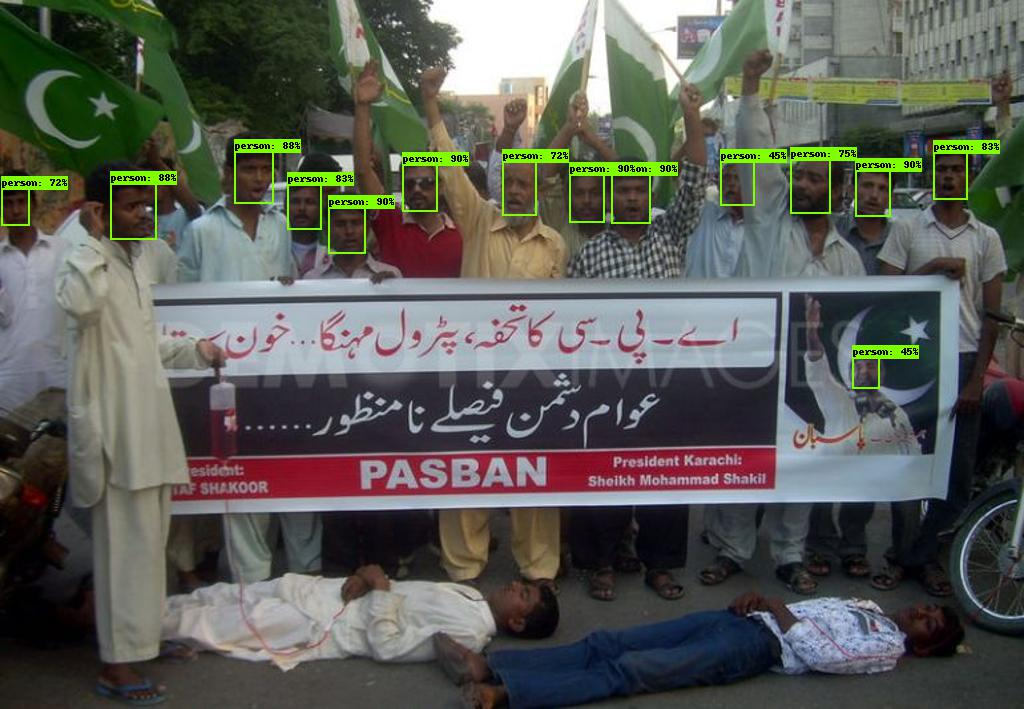

In [62]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))